In [2]:
# !pip install transformers==3.0.2
# !pip install nlp
!which pip

/Users/fyenne/miniforge3/envs/siming/bin/pip


In [3]:
!python -V

Python 3.8.6


In [7]:
# conda install paddlepaddle==2.0.2 -c paddle

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - paddlepaddle==2.0.2

Current channels:

  - https://conda.anaconda.org/paddle/osx-arm64
  - https://conda.anaconda.org/paddle/noarch
  - https://mirrors.ustc.edu.cn/anaconda/cloud/menpo/osx-arm64
  - https://mirrors.ustc.edu.cn/anaconda/cloud/menpo/noarch
  - https://mirrors.ustc.edu.cn/anaconda/cloud/bioconda/osx-arm64
  - https://mirrors.ustc.edu.cn/anaconda/cloud/bioconda/noarch
  - https://mirrors.ustc.edu.cn/anaconda/cloud/msys2/osx-arm64
  - https://mirrors.ustc.edu.cn/anaconda/cloud/msys2/noarch
  - https://mirrors.ustc.edu.cn/anaconda/cloud/conda-forge/osx-arm64
  - https://mirrors.ustc.edu.cn/anaconda/cloud/conda-forge/noarch
  - https://mirrors.ustc.edu.cn/anaconda/pkgs/free/osx-arm64
  - https://mirrors.ustc.edu.cn/a

In [8]:
import transformers
transformers.__version__

'4.5.1'

In [9]:
%connect_info

{
  "shell_port": 58476,
  "iopub_port": 58477,
  "stdin_port": 58478,
  "control_port": 58480,
  "hb_port": 58479,
  "ip": "127.0.0.1",
  "key": "14615488-c756a47067bf264b537b5c61",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-e53baafa-12a0-4725-b21b-8cc19e6eaf5a.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [10]:
import sys
sys.executable

'/Users/fyenne/miniforge3/envs/siming/bin/python'

In [24]:
# !jupyter kernelspec list

In [5]:
import gc
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nlp import load_dataset
from transformers import TFAutoModel, AutoTokenizer

import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(123)

In [12]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [11]:
MODEL = 'jplu/tf-xlm-roberta-large'
# MODEL = 'joeddav/xlm-roberta-large-xnli'

EPOCHS = 4
MAXLEN = 120

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

tokenizer = AutoTokenizer.from_pretrained(MODEL)
auto = tf.data.experimental.AUTOTUNE

NameError: name 'strategy' is not defined

In [12]:
def create_model(transformer_layer,learning_rate):
    input_ids = Input(shape = (MAXLEN,), dtype = tf.int32)
    #input_masks = Input(shape = (MAXLEN,), dtype = tf.int32)

    #insert roberta layer
    roberta = TFAutoModel.from_pretrained(transformer_layer)
    roberta = roberta([input_ids])[0]

    out = GlobalAveragePooling1D()(roberta)

    #add our softmax layer
    out = Dense(3, activation = 'softmax')(out)

    #assemble model and compile
    model = Model(inputs = input_ids, outputs = out)
    model.compile(
                    optimizer = Adam(lr = learning_rate), 
                    loss = 'sparse_categorical_crossentropy', 
                    metrics = ['accuracy'])
    return model


def tokeniZer(text,tokenizer):
    # tokenize
    encoded = tokenizer.batch_encode_plus(text, padding=True, max_length=MAXLEN, truncation=True)
    #return np.array(encoded['input_ids'], encoded['attention_mask'])
    return np.array(encoded['input_ids'])

def tokeniZer_old(dataset,tokenizer):
    # tokenize
    text = dataset[['premise', 'hypothesis']].values.tolist()
    encoded = tokenizer.batch_encode_plus(text, padding=True, max_length=MAXLEN, truncation=True)
    # features
    x = encoded['input_ids'], encoded['attention_mask']
    # labels
    y = None
    if 'label' in dataset.columns:
        y = dataset.label.values
    return encoded['input_ids'], encoded['attention_mask'], y


def load_mnli(use_validation=True):
    result = []
    dataset = load_dataset(path='glue', name='mnli')
    print(dataset['train'])
    keys = ['train', 'validation_matched','validation_mismatched'] if use_validation else ['train']
    for k in keys:
        for record in dataset[k]:
            c1, c2, c3 = record['premise'], record['hypothesis'], record['label']
            if c1 and c2 and c3 in {0,1,2}:
                result.append((c1,c2,c3,'en'))
    result = pd.DataFrame(result, columns=['premise','hypothesis','label','lang_abv'])
    return result

def load_snli(use_validation=True):
    result = []
    dataset = load_dataset(path='snli')
    keys = ['train', 'validation'] if use_validation else ['train']
    for k in keys:
        for record in dataset[k]:
            c1, c2, c3 = record['premise'], record['hypothesis'], record['label']
            if c1 and c2 and c3 in {0,1,2}:
                result.append((c1,c2,c3,'en'))
    result = pd.DataFrame(result, columns=['premise','hypothesis','label','lang_abv'])
    return result

def load_xnli():
    result = []
    dataset = load_dataset(path='xnli')
    for k in dataset.keys():
        for record in dataset[k]:
            hp, pr, lb = record['hypothesis'], record['premise'], record['label']
            if hp and pr and lb in {0,1,2}:
                for lang, translation in zip(hp['language'], hp['translation']):
                    pr_lang = pr.get(lang, None)
                    if pr_lang is None:
                        continue
                    result.append((pr_lang, translation, lb,lang))
    result = pd.DataFrame(result, columns=['premise','hypothesis','label','lang_abv'])
    return result

In [13]:
# load data
train = pd.read_csv('./contradictory-my-dear-watson/train.csv')
test = pd.read_csv('./contradictory-my-dear-watson/test.csv')
submission = pd.read_csv('./contradictory-my-dear-watson/sample_submission.csv')

In [14]:
train.shape

(12120, 6)

In [15]:
train.head()

id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv language  label  
0  The rules developed in the interim were put to...       en  English      0  
1  Practice groups are not permitted to work on t...       en  English      2  
2              J'essayais d'accomplir quelque chose.       fr   French      0  
3  They can't defend themselves because of their ...       en  English      0  
4    เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร       th     Thai      1

---

pretty fucked

In [16]:
# import sentencepiece
# import numpy as np
# mnli = load_mnli()
# from datasets import list_datasets, load_dataset, list_metrics, load_metric
import nlp
from datasets import list_datasets
datasets_list = list_datasets()

In [17]:
# print(', '.join(dataset for dataset in datasets_list))
nlp.__version__

'0.4.0'

In [18]:
# import scipy as sp
path_mnli = '/Users/fyenne/Downloads/booooks/semester5/GLUE-baselines/MNLI/original/glue_data/MNLI/train.tsv'
# mnli = pd.read_csv (path_mnli, sep = '\t', ignore_verifications = True)
# load_dataset(path=path_mnli)

In [19]:

def load_mnli(use_validation=True):
    result = []
    dataset = load_dataset(path=path_mnli)
    # print(dataset['train'])
    keys = ['train', 'validation_matched','validation_mismatched'] if use_validation else ['train']
    for k in keys:
        for record in dataset[k]:
            c1, c2, c3 = record['premise'], record['hypothesis'], record['label']
            if c1 and c2 and c3 in {0,1,2}:
                result.append((c1,c2,c3,'en'))
    result = pd.DataFrame(result, columns=['premise','hypothesis','label','lang_abv'])
    return result

In [23]:
load_dataset('tsv', data_files = path_mnli)

ConnectionError: Couldn't reach https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/tsv/tsv.py

In [50]:
old_data = open(path_mnli).read().split('\t')

In [44]:
old_data[1:25]

['promptID',
 'pairID',
 'genre',
 'sentence1_binary_parse',
 'sentence2_binary_parse',
 'sentence1_parse',
 'sentence2_parse',
 'sentence1',
 'sentence2',
 'label1',
 'gold_label\n0',
 '31193',
 '31193n',
 'government',
 '( ( Conceptually ( cream skimming ) ) ( ( has ( ( ( two ( basic dimensions ) ) - ) ( ( product and ) geography ) ) ) . ) )',
 '( ( ( Product and ) geography ) ( ( are ( what ( make ( cream ( skimming work ) ) ) ) ) . ) )',
 '(ROOT (S (NP (JJ Conceptually) (NN cream) (NN skimming)) (VP (VBZ has) (NP (NP (CD two) (JJ basic) (NNS dimensions)) (: -) (NP (NN product) (CC and) (NN geography)))) (. .)))',
 '(ROOT (S (NP (NN Product) (CC and) (NN geography)) (VP (VBP are) (SBAR (WHNP (WP what)) (S (VP (VBP make) (NP (NP (NN cream)) (VP (VBG skimming) (NP (NN work)))))))) (. .)))',
 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'Product and geography are what make cream skimming work. ',
 'neutral',
 'neutral\n1',
 '101457',
 '101457e']

In [22]:
mnli = load_mnli()

ModuleNotFoundError: No module named 'nlp.datasets.train'

---


In [17]:
mnli# shape (412349, 4)

array([nan, nan, nan, ..., nan, nan, nan])

In [21]:
total_train = train.drop(columns=['id'])
total_train = pd.concat([total_train, mnli], axis=0)

shuffled_data = shuffle(total_train).reset_index(drop = True)

X, y = shuffled_data[['premise', 'hypothesis']].values.tolist(), shuffled_data['label']

NameError: name 'mnli' is not defined

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2020)

In [14]:
x_train = tokeniZer(x_train,tokenizer)
x_valid = tokeniZer(x_valid,tokenizer)
x_test  = tokeniZer(test[['premise', 'hypothesis']].values.tolist(),tokenizer)

del mnli
gc.collect()

0

In [15]:
# datasets
def build_dataset(x, y, mode, batch_size):
    if mode == "train":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices((x, y))
            .repeat()
            .shuffle(2048)
            .batch(batch_size)
            .prefetch(auto)
        )
    elif mode == "valid":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices((x, y))
            .batch(BATCH_SIZE)
            .cache()
            .prefetch(auto)
        )
    elif mode == "test":
        dataset = (
            tf.data.Dataset
            .from_tensor_slices(x)
            .batch(BATCH_SIZE)
        )
    else:
        raise NotImplementedError
    return dataset

In [16]:
train_dataset = build_dataset(x_train, y_train, "train", BATCH_SIZE)
valid_dataset = build_dataset(x_valid, y_valid, "valid", BATCH_SIZE)
test_dataset  = build_dataset(x_test, None, "test", BATCH_SIZE)

In [17]:
def create_xlm(transformer_layer,random_seed,learning_rate):
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)
    with strategy.scope():
        model = create_model(transformer_layer,learning_rate)
    model.summary()    
    return model

In [18]:
Xlm = create_xlm(MODEL,1124234,1e-5)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 120, 1024), (None 559890432 
_________________________________________________________________
global_average_pooling1d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,893,507
Trainable params: 559,893,507
Non-trainable params: 0
_________________________________________________________________


In [19]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience = 2, 
                                              monitor = 'val_loss', 
                                              restore_best_weights = True, 
                                              mode = 'min')]

steps_per_epoch = len(x_train) // BATCH_SIZE
history_xlm = Xlm.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch=steps_per_epoch,
                      epochs = EPOCHS, 
                      callbacks = callbacks)



Epoch 1/4


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


2487/2487 [==============================] - 879s 353ms/step - accuracy: 0.9197 - loss: 0.2271 - val_accuracy: 0.9352 - val_loss: 0.1869
Epoch 2/4
2487/2487 [==============================] - 822s 331ms/step - accuracy: 0.9408 - loss: 0.1695 - val_accuracy: 0.9333 - val_loss: 0.1969
Epoch 3/4
2487/2487 [==============================] - 852s 342ms/step - accuracy: 0.9564 - loss: 0.1281 - val_accuracy: 0.9284 - val_loss: 0.2211


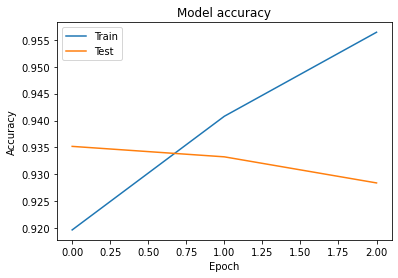

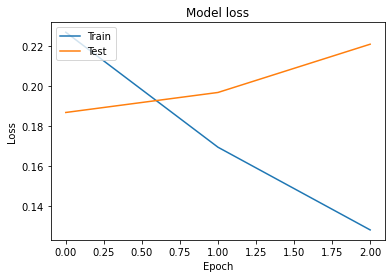

In [20]:
plt.plot(history_xlm.history['accuracy'])
plt.plot(history_xlm.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_xlm.history['loss'])
plt.plot(history_xlm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
#model predictions
predictions_xlm = Xlm.predict(test_dataset)
predictions = predictions_xlm
final = np.argmax(predictions, axis = 1)    

submission = pd.DataFrame()    
submission['id'] = test['id']
submission['prediction'] = final.astype(np.int32)

submission.to_csv('submission.csv', index = False)

In [22]:
submission.head()

id  prediction
0  c6d58c3f69           2
1  cefcc82292           1
2  e98005252c           0
3  58518c10ba           1
4  c32b0d16df           1